In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.integrate import odeint
import scipy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

In [2]:
#algorithm for splitting the dataset into training and validation 
def split(X,Y,porcent): #porcent must be between 0 and 1, it is the asigned porcent to the training dataset.
    n=floor(porcent*len(X))
    index=random.sample(range(len(X)),n)
    X_learn=[]
    Y_learn=[]
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val=np.delete(X,index, axis=0)
    Y_val=np.delete(Y,index, axis=0)
    
    X_learn=np.array(X_learn)
    Y_learn=np.array(Y_learn)
    return X_learn,Y_learn,X_val,Y_val

In [3]:
O_m=np.arange(0.1,0.51,0.1)
H_0=np.arange(66,81,0.05)
t=np.linspace(0,-12,50)

In [4]:
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    #x, y, z = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    #return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om,H0):
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    #H0 = 70.
    y0 = [Om, Or, Ol, H0]
    result = odeint(RHS, y0, t)
    return result

In [5]:
#lets generate the cartesian product between the intervals
Y0=[]
#este ciclo llena la lista fijando un Om y pasando todos los Or
for i in O_m:
    for j in H_0:
        Y0.extend(EDO(t,i,j))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for H0 in H_0:
        for T in t:
            X0.append([T,Om,H0])
X0=np.array(X0)

In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
Y2 = scaler.fit_transform(Y0)

In [7]:
#Now, here are the datasets
print('feactures= \n',X0)
print('\n')
print('labels= \n',Y2)

feactures= 
 [[  0.           0.1         66.        ]
 [ -0.24489796   0.1         66.        ]
 [ -0.48979592   0.1         66.        ]
 ...
 [-11.51020408   0.5         80.95      ]
 [-11.75510204   0.5         80.95      ]
 [-12.           0.5         80.95      ]]


labels= 
 [[9.47515373e-02 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.83608702e-01 1.41110961e-04 9.01997379e-01 1.60453112e-10]
 [3.22333902e-01 4.33937896e-04 7.48914062e-01 4.71545340e-10]
 ...
 [4.20164900e-02 9.58104047e-01 5.58396455e-11 3.78984027e-01]
 [3.19464665e-02 9.68145182e-01 5.73929718e-11 6.15280156e-01]
 [2.39153274e-02 9.76153281e-01 5.75118135e-11 1.00000000e+00]]


In [8]:
#Separamos los datos en validación y entrenamiento
X_learn, Y_learn, X_val, Y_val = split(X0, Y2, 0.8)



In [9]:
epochs=500
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=100,
                                   restore_best_weights=True, verbose=False)
                                   ]

In [10]:
def train_test_model(hparams, X_train, Y_train, X_test, Y_test):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(4, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=False)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

# Grid

- layers 3 	
- nodes 200 	
- lr 0.00010 	
- bs 16 	

loss = 0.000225 

In [11]:
hparams_grid = {'HP_LAYERS': 3, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.0001}
model_grid, loss_grid, history_grid = train_test_model(hparams_grid, X_learn, Y_learn, X_val, Y_val)

469/469 [==============================] - 0s 626us/step - loss: 2.3206e-06 - mean_squared_error: 2.3206e-06


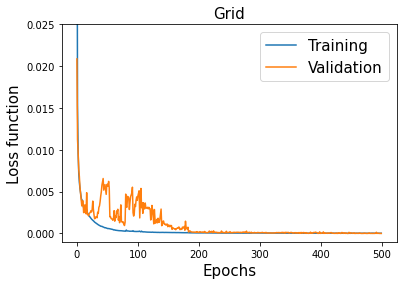

In [28]:
plt.plot(history_grid['loss'], label='Training')
plt.plot(history_grid['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.title("Grid", fontsize=15)
plt.ylim(-0.001, 0.025)
plt.savefig("loss_grid_ecs.png")

In [13]:
loss_grid

2.3206291643873556e-06

In [32]:
model_grid.save("models/model_ecsdif_grid.h5")

# Genetic

- layers 4
- number of neurons: 100
- Batch size 4
- Learning rate: 0.0001

loss = 0.000026

In [14]:
hparams_gen = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 100, 'HP_BATCHSIZE': 4, 'HP_LEARNING':0.0001}
model_gen, loss_gen, history_gen = train_test_model(hparams_gen, X_learn, Y_learn, X_val, Y_val)

469/469 [==============================] - 0s 638us/step - loss: 2.3129e-06 - mean_squared_error: 2.3129e-06


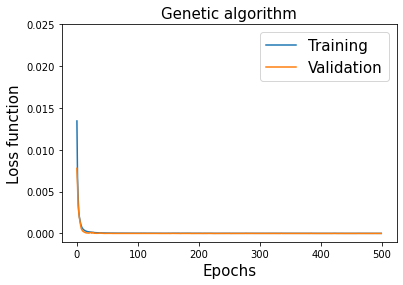

In [29]:
plt.plot(history_gen['loss'], label='Training')
plt.plot(history_gen['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.title("Genetic algorithm", fontsize=15)
plt.ylim(-0.001, 0.025)
plt.savefig("loss_gen_ecs.png")

In [33]:
model_gen.save("models/model_ecsdif_genetic.h5")

In [16]:
loss_gen

2.3128882276068907e-06

2/2 [==============================] - 0s 1ms/step


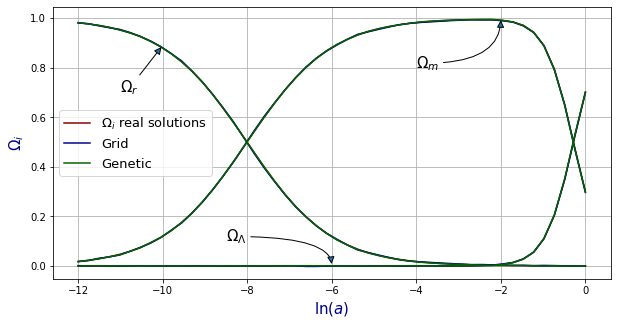

In [17]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#different combinations for the params

for z in Z: dom.append([z,0.5,80]) 
# A=model.predict(dom)               
# # ¡¡¡ The inverse transformation must be applied in order to return the labels to their original ranges!!!
# A=scaler.inverse_transform(A) 

for z in Z: dom2.append([z,0.3,70]) 
B_grid=model_grid.predict(dom2)
B_grid=scaler.inverse_transform(B_grid)

B_gen=model_gen.predict(dom2)
B_gen=scaler.inverse_transform(B_gen)

for z in Z: dom3.append([z,0.4,67]) 
C_grid=model_grid.predict(dom3)
C_grid=scaler.inverse_transform(C_grid)
C_gen=model_gen.predict(dom3)
C_gen=scaler.inverse_transform(C_gen)
#función real
D=EDO(Z, 0.3,70)

plt.figure(figsize=(10,5))

plt.plot(Z,D[:,0],color='darkred')
plt.plot(Z,D[:,1],color='darkred')
plt.plot(Z,D[:,2],color='darkred', label='$\Omega_i$ real solutions')

#Realvs model
plt.plot(Z,B_grid[:,0],color='darkblue')
plt.plot(Z,B_grid[:,1],color='darkblue')
plt.plot(Z,B_grid[:,2],color='darkblue', label='Grid')
#plt.plot(Z,B[:,3])

plt.plot(Z,B_gen[:,0],color='darkgreen')
plt.plot(Z,B_gen[:,1],color='darkgreen')
plt.plot(Z,B_gen[:,2],color='darkgreen', label='Genetic')
#plt.plot(Z,B[:,3])

#plt.plot(Z,D[:,3])

#plt.title()
plt.xlabel('$\ln(a)$', size=15, color='darkblue')
plt.ylabel('$\Omega_i$', size=15, color='darkblue')
plt.grid()
plt.legend(fontsize=13)

plt.annotate('$\Omega_m$', xy=(-2,1), xytext=(-4,0.8), size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=-90"))

plt.annotate('$\Omega_r$', xy=(-10,0.89), xytext=(-11,0.7),size=15,
           arrowprops=dict(arrowstyle='-|>'))

plt.annotate('$\Omega_{\Lambda}$', xy=(-6,0), xytext=(-8.5,0.1),size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=90"))

#plt.savefig('red_vs_sol.pdf')
# plt.yscale('log')
plt.savefig('ecs_dif.png')